In [1]:
import os
import numpy as np 
import pandas as pd
from scipy import stats, signal, io
import mne
from mne import create_info, EpochsArray
from mne.time_frequency import tfr_morlet
from bids import BIDSLayout
import mne_bids
import scipy
#import settings
import json
#from coordinates_io import BIDS_coord
from sklearn import linear_model, metrics
import multiprocessing
from sklearn.model_selection import cross_val_score
from sklearn import ensemble, model_selection
from matplotlib import pyplot as plt
import matplotlib 

In [2]:
BIDS_path = 'C:\\Users\\ICN_admin\\Dropbox (Brain Modulation Lab)\\Shared Lab Folders\\CRCNS\\MOVEMENT DATA\\'
subject_id = ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']
out_path = "C:\\Users\\ICN_admin\\Documents\\ECOGVSTN\\dat\\"

In [3]:
subject_exclude = ['002', '003', '011', '012', '015', '016']
subject_tf_usage = ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014', '016']
#002 - DBS4011 - no locaization possible
#003 - DBS4020 - LEFT due to signal quality
#011 - DBS4037 - STN was not recorded
#012 - DBS4030 - GPi not STN 
#015 - DBS4065 - LEFT due to signal quality

In [4]:
# setup plot where STN and ECOG is visible 
faces = io.loadmat('faces.mat')
Vertices = io.loadmat('Vertices.mat')
grid = io.loadmat('grid.mat')['grid']
stn_surf = io.loadmat('STN_surf.mat')
x_ = stn_surf['vertices'][::2,0]
y_ = stn_surf['vertices'][::2,1]
x_ecog = Vertices['Vertices'][::1,0]
y_ecog = Vertices['Vertices'][::1,1]
x_stn = stn_surf['vertices'][::1,0]
y_stn = stn_surf['vertices'][::1,1]

FileNotFoundError: [Errno 2] No such file or directory: 'faces.mat'

In [ ]:
font = {'size'   : 12}

matplotlib.rc('font', **font)

In [6]:
def get_x_y(dict_ch, ind_, Con=True, return_z=False):
    
    channels = list(dict_ch.keys())
    x_choord = np.zeros(len(ind_))
    y_choord = np.zeros(len(ind_))
    z_choord = np.zeros(len(ind_))
    for idx, ind_ch in enumerate(ind_): 
        choord = np.squeeze(np.array(dict_ch[channels[ind_ch]]["choords"]))
        x_choord[idx] = choord[0]
        y_choord[idx] = choord[1]
        z_choord[idx] = choord[2]
        
        #wähle den contralateralen channel aus
        #mov_channels = dict_ch[channels[ind_ch]]['mov_ch']
        #mov_idx = get_movement_idx(channels[ind_ch], mov_channels, Con)

    if return_z is True:
        return x_choord, y_choord, z_choord
    return x_choord, y_choord

In [7]:
subject_id = []
for patient_test in range(17):
    if patient_test < 10:
        subject_id.append(str('00') + str(patient_test))
    else:
        subject_id.append(str('0') + str(patient_test))


In [8]:
def get_movement_idx(ch, mov_channels, Con=True):
    mov_idx = 0
    if len(mov_channels) > 1:    
        if Con is True:
            if ("RIGHT" in ch and "LEFT" in mov_channels[0]) or \
                ("LEFT" in ch and "RIGHT" in mov_channels[0]):
                mov_idx = 0
            if ("RIGHT" in ch and "LEFT" in mov_channels[1]) or \
                ("LEFT" in ch and "RIGHT" in mov_channels[1]):
                mov_idx = 1
        else:
            if ("RIGHT" in ch and "RIGHT" in mov_channels[0]) or \
                ("LEFT" in ch and "LEFT" in mov_channels[0]):
                mov_idx = 0
            if ("RIGHT" in ch and "RIGHT" in mov_channels[1]) or \
                ("LEFT" in ch and "LEFT" in mov_channels[1]):
                mov_idx = 1
    return mov_idx

### Plot all Electrodes

In [59]:
def plot_all_electrodes(out_path, Con=True):
    height_STN = 1
    height_ECOG = 2.5*height_STN
    
    rows=6; columns = 4
    
    fig, axes = plt.subplots(rows,columns, facecolor=(1,1,1), gridspec_kw={'height_ratios': [height_ECOG, height_STN]*3}, \
                             figsize=(17,17))#, dpi=700)
    x_cnt_ECOG, y_cnt_ECOG, x_cnt_STN, y_cnt_STN = 0,0,0,1

    for sub_idx, subject_id_ in enumerate(subject_id):    
        if subject_id_ in subject_exclude: 
                continue
        with open(out_path+'sub_'+subject_id_+'_patient_concat.json', 'r') as fp:
            dict_ch = json.load(fp)
        channels = list(dict_ch.keys())
        ind_ECOG = [ch_idx for ch_idx,ch in enumerate(list(dict_ch.keys())) if ch.startswith("ECOG")]
        ind_STN = [ch_idx for ch_idx,ch in enumerate(list(dict_ch.keys())) if ch.startswith("STN")]


        axes[y_cnt_ECOG, x_cnt_ECOG].scatter(x_ecog, y_ecog, c="gray", s=0.0001)
        axes[y_cnt_ECOG, x_cnt_ECOG].set_title('sub'+subject_id_, color='black')
        axes[y_cnt_ECOG, x_cnt_ECOG].set_axis_off()
        x,y = get_x_y(dict_ch, ind_ECOG, Con)
        c = np.ones(x.shape[0])
        if subject_id_ == '001' or subject_id_ == '006':
            pos_ecog = axes[y_cnt_ECOG, x_cnt_ECOG].scatter(x, y, c=c, s=2, cmap='hot')
        else:
            pos_ecog = axes[y_cnt_ECOG, x_cnt_ECOG].scatter(x, y, c=c, s=15, cmap='hot')
        cbar_ecog = fig.colorbar(pos_ecog, ax=axes[y_cnt_ECOG, x_cnt_ECOG]); pos_ecog.set_clim(1,1.4); cbar_ecog.remove()

        pos_stn = axes[y_cnt_STN, x_cnt_STN].scatter(x_stn, y_stn, c="gray", s=0.0001)

        if subject_id_ not in ['012', '003']:

            x,y = get_x_y(dict_ch, ind_STN, Con)
            c = np.ones(x.shape[0])
            if subject_id_ == '016':
                pos_stn = axes[y_cnt_STN, x_cnt_STN].scatter(x, y, c=c, s=10, cmap='hot')
            else:
                pos_stn = axes[y_cnt_STN, x_cnt_STN].scatter(x, y, c=c, s=15, cmap='hot')
        cbar_stn = fig.colorbar(pos_stn, ax=axes[y_cnt_STN, x_cnt_STN]); pos_stn.set_clim(1,1.4); cbar_stn.remove()

        axes[y_cnt_STN, x_cnt_STN].axes.set_aspect('equal', anchor='C')
        axes[y_cnt_STN, x_cnt_STN].set_facecolor((1,1,1))
        axes[y_cnt_STN, x_cnt_STN].set_axis_off()
        axes[y_cnt_ECOG, x_cnt_ECOG].axes.set_aspect('equal', anchor='C')
        axes[y_cnt_ECOG, x_cnt_ECOG].set_facecolor((1,1,1))

        x_cnt_ECOG = x_cnt_ECOG + 1
        x_cnt_STN = x_cnt_ECOG

        if x_cnt_ECOG == 4:
            y_cnt_ECOG = y_cnt_ECOG + 2
            y_cnt_STN = y_cnt_ECOG + 1
            x_cnt_ECOG, x_cnt_STN = 0, 0

    axes[4, 3].set_facecolor((1,1,1)); axes[4, 3].set_axis_off()
    axes[5, 3].set_facecolor((1,1,1)); axes[5, 3].set_axis_off()
    #axes[6, 3].set_facecolor((1,1,1)); axes[6, 3].set_axis_off()
    #axes[7, 1].set_facecolor((1,1,1)); axes[7, 1].set_axis_off()
    #axes[7, 2].set_facecolor((1,1,1)); axes[7, 2].set_axis_off()
    #axes[7, 3].set_facecolor((1,1,1)); axes[7, 3].set_axis_off()

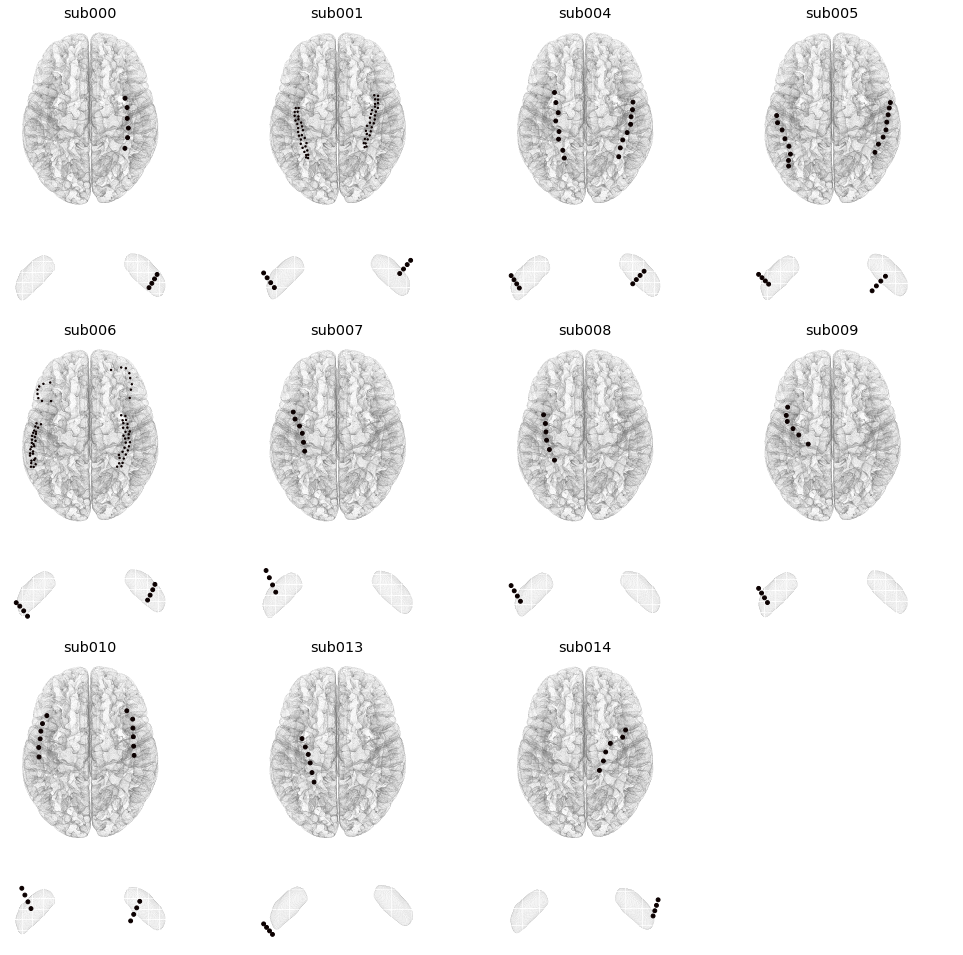

In [60]:
plot_all_electrodes(out_path)